# Final Project

## Water quality classification

https://www.kaggle.com/datasets/mssmartypants/water-quality

In [1]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from time import gmtime, strftime
import urllib.request, json, os, sagemaker
from sagemaker import get_execution_role
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [2]:
my_region = boto3.session.Session().region_name
prefix = 'sagemaker/MLI-Lab_solution'

print("Region: {}".format(my_region))

Region: us-west-2


In [3]:
s3 = boto3.resource('s3')

bucket_name = 'bah-sagemaker-final-project'

In [4]:
try:
    if  my_region == 'us-east-1':
        if not s3.Bucket(bucket_name).creation_date:
            s3.create_bucket(Bucket=bucket_name)
            print('S3 bucket created successfully')
        else:
            print('Bucket already exists!')
    else: 
        if not s3.Bucket(bucket_name).creation_date:
            s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': my_region})
            print('S3 bucket created successfully')
        else:
            print('Bucket already exists!')
except Exception as e:
    print('S3 error: ', e)

Bucket already exists!


In [5]:
import os

DATASET = 'waterQuality.csv'
DATA_FOLDER = 's3://bah-data'

data = pd.read_csv(os.path.join(DATA_FOLDER, DATASET))

Columns description

- aluminium - dangerous if greater than 2.8
- ammonia - dangerous if greater than 32.5
- arsenic - dangerous if greater than 0.01
- barium - dangerous if greater than 2
- cadmium - dangerous if greater than 0.005
- chloramine - dangerous if greater than 4
- chromium - dangerous if greater than 0.1
- copper - dangerous if greater than 1.3
- flouride - dangerous if greater than 1.5
- bacteria - dangerous if greater than 0
- viruses - dangerous if greater than 0
- lead - dangerous if greater than 0.015
- nitrates - dangerous if greater than 10
- nitrites - dangerous if greater than 1
- mercury - dangerous if greater than 0.002
- perchlorate - dangerous if greater than 56
- radium - dangerous if greater than 5
- selenium - dangerous if greater than 0.5
- silver - dangerous if greater than 0.1
- uranium - dangerous if greater than 0.3
- is_safe - class attribute {0 - not safe, 1 - safe}

In [6]:
data.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [7]:
data.isnull().any()

aluminium      False
ammonia        False
arsenic        False
barium         False
cadmium        False
chloramine     False
chromium       False
copper         False
flouride       False
bacteria       False
viruses        False
lead           False
nitrates       False
nitrites       False
mercury        False
perchlorate    False
radium         False
selenium       False
silver         False
uranium        False
is_safe        False
dtype: bool

In [8]:
data.describe()

,aluminium,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
count,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000
mean,0.666158,0.161445,1.567715,0.042806,2.176831,0.247226,0.805857,0.771565,0.319665,0.328583,0.099450,9.818822,1.329961,0.005194,16.460299,2.920548,0.049685,0.147781,0.044673
std,1.265145,0.252590,1.216091,0.036049,2.567027,0.270640,0.653539,0.435373,0.329485,0.378096,0.058172,5.541331,0.573219,0.002967,17.687474,2.323009,0.028770,0.143551,0.026904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.030000,0.560000,0.008000,0.100000,0.050000,0.090000,0.405000,0.000000,0.002000,0.048000,5.000000,1.000000,0.003000,2.170000,0.820000,0.020000,0.040000,0.020000
50%,0.070000,0.050000,1.190000,0.040000,0.530000,0.090000,0.750000,0.770000,0.220000,0.008000,0.102000,9.930000,1.420000,0.005000,7.740000,2.410000,0.050000,0.080000,0.050000
75%,0.280000,0.100000,2.480000,0.070000,4.240000,0.440000,1.390000,1.160000,0.610000,0.700000,0.151000,14.610000,1.760000,0.008000,29.480000,4.670000,0.070000,0.240000,0.070000
max,5.050000,1.050000,4.940000,0.130000,8.680000,0.900000,2.000000,1.500000,1.000000,1.000000,0.200000,19.830000,2.930000,0.010000,60.010000,7.990000,0.100000,0.500000,0.090000


In [9]:
data = data.rename(columns={'is_safe': 'label'})

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [11]:
data['label'].value_counts()

0        7084
1         912
#NUM!       3
Name: label, dtype: int64

In [12]:
data = data.loc[data['label'] != '#NUM!']

In [13]:
data['label'] = data['label'].astype(int)

In [14]:
data['ammonia'] = data['ammonia'].astype(float)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7996 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7996 non-null   float64
 1   ammonia      7996 non-null   float64
 2   arsenic      7996 non-null   float64
 3   barium       7996 non-null   float64
 4   cadmium      7996 non-null   float64
 5   chloramine   7996 non-null   float64
 6   chromium     7996 non-null   float64
 7   copper       7996 non-null   float64
 8   flouride     7996 non-null   float64
 9   bacteria     7996 non-null   float64
 10  viruses      7996 non-null   float64
 11  lead         7996 non-null   float64
 12  nitrates     7996 non-null   float64
 13  nitrites     7996 non-null   float64
 14  mercury      7996 non-null   float64
 15  perchlorate  7996 non-null   float64
 16  radium       7996 non-null   float64
 17  selenium     7996 non-null   float64
 18  silver       7996 non-null   float64
 19  uraniu

In [44]:
corr = data.corr()
corr

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,label
aluminium,1.000000,0.067369,0.225725,0.294091,-0.099902,0.369221,0.353134,0.168569,-0.009877,-0.078324,...,0.020957,-0.003851,0.237439,-0.003129,0.362986,0.243396,-0.003651,0.334923,0.014723,0.333974
ammonia,0.067369,1.000000,0.046783,0.070099,-0.006422,0.104775,0.124782,0.015953,-0.028221,0.063603,...,-0.037065,0.006483,-0.063309,0.020884,0.090928,0.050401,0.029897,0.075547,0.014635,-0.022919
arsenic,0.225725,0.046783,1.000000,0.362925,0.334782,0.356509,0.312421,-0.036488,0.003731,0.035642,...,-0.087669,0.027533,0.305113,-0.015288,0.332228,0.218328,-0.006993,0.307794,0.001469,-0.123362
barium,0.294091,0.070099,0.362925,1.000000,-0.037901,0.446869,0.415937,0.065277,-0.018637,0.101304,...,-0.042829,-0.011423,0.312783,0.006165,0.462207,0.286890,0.035222,0.431542,-0.002541,0.090858
cadmium,-0.099902,-0.006422,0.334782,-0.037901,1.000000,-0.144366,-0.157716,-0.109252,0.005005,-0.092133,...,-0.035313,0.020232,-0.015829,-0.016169,-0.149269,-0.098936,0.009933,-0.155441,-0.005911,-0.256034
chloramine,0.369221,0.104775,0.356509,0.446869,-0.144366,1.000000,0.555846,0.118975,0.004254,0.154443,...,-0.030241,-0.001619,0.379916,-0.021198,0.588683,0.389119,0.011435,0.522372,-0.007648,0.186704
chromium,0.353134,0.124782,0.312421,0.415937,-0.157716,0.555846,1.000000,0.113003,-0.002424,0.141937,...,-0.050254,-0.012843,0.335940,-0.022541,0.524432,0.315484,0.030598,0.510705,-0.005472,0.182306
copper,0.168569,0.015953,-0.036488,0.065277,-0.109252,0.118975,0.113003,1.000000,0.011647,0.149271,...,0.121762,0.002259,0.162092,0.017785,0.104527,0.026534,-0.003356,0.089241,0.006802,0.029498
flouride,-0.009877,-0.028221,0.003731,-0.018637,0.005005,0.004254,-0.002424,0.011647,1.000000,0.013984,...,0.012146,-0.008245,-0.016591,-0.004263,-0.016352,0.007683,0.022726,0.014446,0.016849,0.006550
bacteria,-0.078324,0.063603,0.035642,0.101304,-0.092133,0.154443,0.141937,0.149271,0.013984,1.000000,...,-0.027179,-0.033993,0.246463,-0.004406,0.147526,0.099080,-0.006779,0.148199,0.045077,-0.022077


<AxesSubplot: >

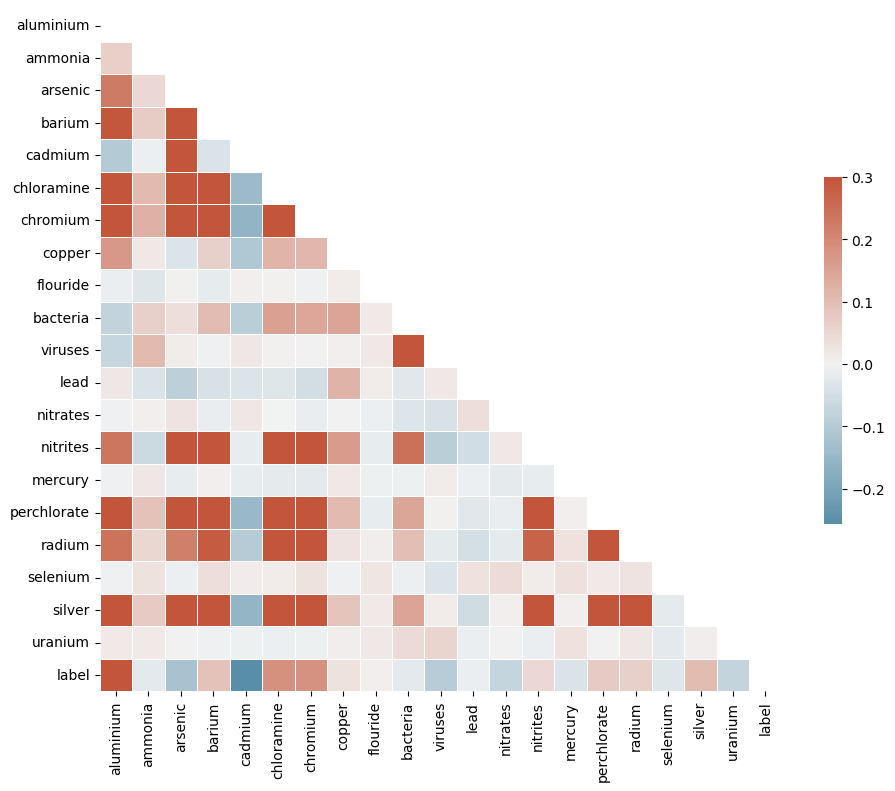

In [43]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
y = data['label']
X = data.drop('label', axis=1)

In [18]:
# Since classes are not balanced, let's use stratify data split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    stratify=y)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, 
                                                            test_size = 0.2,
                                                            train_size =0.8,
                                                            stratify=y_train)

train_data = pd.concat([x_train, y_train], axis=1)
validation_data = pd.concat([x_validate, y_validate], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

print(train_data.shape, test_data.shape, validation_data.shape)

(5116, 21) (1600, 21) (1280, 21)


In [19]:
label_column = train_data['label']
train_data = train_data.drop(['label'], axis=1)
train_data = pd.concat([label_column, train_data], axis=1)

train_data.to_csv('train.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='text/csv')

In [20]:
train_data.head()

,label,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,...,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
5744,0,0.04,25.67,0.06,0.82,0.02,0.74,0.01,1.62,1.48,...,0.990,0.162,1.97,0.06,0.003,4.60,0.12,0.02,0.09,0.04
3721,0,0.01,19.77,0.47,0.32,0.11,6.81,0.84,0.09,0.83,...,0.008,0.018,1.05,1.71,0.009,38.15,2.15,0.03,0.21,0.04
7123,0,0.07,5.33,0.04,0.30,0.09,0.07,0.03,0.02,0.04,...,0.760,0.198,10.81,1.47,0.006,0.92,0.20,0.06,0.10,0.02
5983,0,0.09,4.28,0.06,0.85,0.09,0.20,0.06,1.69,0.11,...,0.008,0.058,9.03,0.18,0.001,8.37,1.35,0.00,0.01,0.09
3989,0,0.04,18.07,0.67,2.38,0.07,8.01,0.36,0.10,0.44,...,0.000,0.047,14.62,1.53,0.002,20.77,3.95,0.05,0.46,0.00


In [21]:
label_column = validation_data['label']
validation_data = validation_data.drop(['label'], axis=1)
validation_data = pd.concat([label_column, validation_data], axis=1)

validation_data.to_csv('validation.csv', index=False, header=False)

boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "validation/validation.csv")).upload_file("validation.csv")

s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket_name, prefix), content_type='text/csv')

In [22]:
validation_data.head()

,label,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,...,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
6507,0,0.09,4.32,0.04,0.59,0.010,0.00,0.03,0.11,1.46,...,0.750,0.005,7.38,1.03,0.002,4.64,1.97,0.07,0.00,0.07
5915,0,0.07,4.90,0.05,1.03,0.030,0.07,0.03,0.29,1.14,...,0.770,0.174,9.85,0.85,0.006,7.29,0.32,0.04,0.06,0.09
5993,0,0.10,14.35,0.02,0.15,0.010,0.59,0.06,1.47,0.15,...,0.002,0.085,19.55,0.93,0.001,0.16,1.42,0.05,0.10,0.07
2708,0,0.05,23.92,0.05,0.52,0.006,7.48,0.07,0.64,0.43,...,0.002,0.059,16.37,1.75,0.006,52.24,0.97,0.03,0.23,0.06
3860,0,0.07,14.63,0.59,3.14,0.040,1.21,0.29,0.04,0.47,...,0.740,0.175,13.23,1.33,0.005,34.94,4.45,0.07,0.19,0.07


In [23]:
sess = sagemaker.Session()
role = get_execution_role()

In [24]:
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

In [25]:
xgb = sagemaker.estimator.Estimator(xgboost_container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket_name, prefix),
                                    sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [26]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        eval_metric='auc',
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [27]:
xgb.fit({'train': s3_input_train})

INFO:sagemaker:Creating training-job with name: xgboost-2023-03-29-13-54-34-025


2023-03-29 13:54:34 Starting - Starting the training job...
2023-03-29 13:54:58 Starting - Preparing the instances for training.........
2023-03-29 13:56:18 Downloading - Downloading input data...
2023-03-29 13:56:43 Training - Downloading the training image...
2023-03-29 13:57:19 Training - Training image download completed. Training in progress..Arguments: train
[2023-03-29:13:57:32:INFO] Running standalone xgboost training.
[2023-03-29:13:57:32:INFO] Path /opt/ml/input/data/validation does not exist!
[2023-03-29:13:57:32:INFO] File size need to be processed in the node: 0.51mb. Available memory size in the node: 8613.12mb
[2023-03-29:13:57:32:INFO] Determined delimiter of CSV input is ','
[13:57:32] S3DistributionType set as FullyReplicated
[13:57:32] 5116x20 matrix with 102320 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[13:57:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=5
[0]#011train-

In [28]:
objective_metric_name = "validation:auc"
MAX_JOBS = 3
MAX_PARALLEL_JOBS = 4
STRATEGY = 'Random'
SCALING_TYPE = 'Logarithmic'

In [29]:
tuninig_job_name = "xgb-linsearch-" + strftime("%Y%m%d-%H-%M-%S", gmtime())

hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 0.5, scaling_type=SCALING_TYPE),
    "lambda": ContinuousParameter(0.05, 0.5, scaling_type=SCALING_TYPE),
}

In [30]:
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=MAX_JOBS,
    max_parallel_jobs=MAX_PARALLEL_JOBS,
    strategy=STRATEGY,
)

In [31]:
tuner_linear.fit(
    {"train": s3_input_train, 
     "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name=tuninig_job_name)

INFO:sagemaker:Creating hyperparameter tuning job with name: xgb-linsearch-20230329-13-58-18


..............................................!


In [32]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuninig_job_name)

full_df = tuner.dataframe()
full_df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
full_df

,alpha,lambda,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.062350,0.075010,xgb-linsearch-20230329-13-58-18-003-f7b500b5,Completed,0.989315,2023-03-29 14:00:03+00:00,2023-03-29 14:01:50+00:00,107.0
1,0.484442,0.146138,xgb-linsearch-20230329-13-58-18-002-fb48e8e9,Completed,0.989249,2023-03-29 13:59:55+00:00,2023-03-29 14:01:27+00:00,92.0
2,0.174092,0.195695,xgb-linsearch-20230329-13-58-18-001-8b6700d5,Completed,0.989333,2023-03-29 14:00:19+00:00,2023-03-29 14:01:51+00:00,92.0


In [33]:
xgb_predictor = tuner_linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-03-29-14-02-14-803
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-03-29-14-02-14-803
INFO:sagemaker:Creating endpoint with name xgboost-2023-03-29-14-02-14-803


-------!

In [34]:
y = test_data['label']
test_data_array = test_data.drop(['label'], axis=1).values

In [35]:
xgb_predictor.serializer = csv_serializer

In [36]:
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')
predictions_array = np.fromstring(predictions[1:], sep=',')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [37]:
y_pred = pd.Series(np.where(predictions_array>0.3, 1, 0))

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1418
           1       0.85      0.80      0.82       182

    accuracy                           0.96      1600
   macro avg       0.91      0.89      0.90      1600
weighted avg       0.96      0.96      0.96      1600



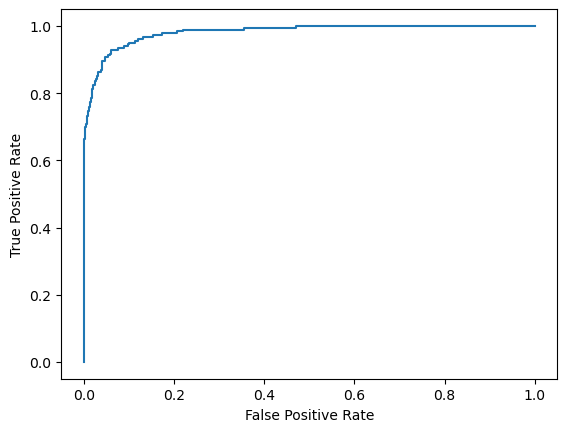

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y,  predictions_array)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<AxesSubplot: >

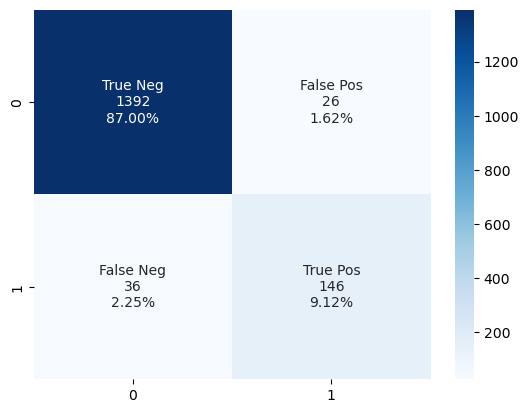

In [40]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
sess.delete_endpoint(endpoint_name=xgb_predictor.endpoint_name)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()